# Exercise 2

This structre of the file is as follows:

1. Imports, functions and constants
2. Data cleaning and filling
3. Describe data
4. Question 3 - Demographic analysis
5. Question 4 - RandomForest predicts valid votes
6. Question 5 - Adaboost predicts votes for parties
7. Question 6 - Minimize disqualified votes 

# Imports, functions and constants

This section was made to make the file a little more organized.

In [104]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn import mixture
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import plotly.graph_objects as go
from sklearn import  metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict 
from operator import itemgetter
import itertools

In [105]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170
VOTES_THRESHOLD = 135720

# bycode 2018 excel
BYCODE = os.path.join(ROOT_PATH,"bycode2018.xlsx")

# index 2018 excel
INDEX = os.path.join(ROOT_PATH,"index 2018.xlsx")

# sheets in index 2018
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement type"


# elections data
SETTELMENT21 = os.path.join(ROOT_PATH,"21settelments.xlsx")
SETTELMENT22 = os.path.join(ROOT_PATH,"22settelments.xlsx")
SETTELMENT23 = os.path.join(ROOT_PATH,"23settelments.xlsx")

CALPI21 = os.path.join(ROOT_PATH,"21calpi.xlsx")


In [106]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    df = pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)
    df.drop_duplicates(inplace=True)
    return df

def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
   
    columns = ['Haredi','Right','Arab','Left','Likud','Blue and white']
    df = df_original.copy()
    df = df[columns].astype(float)
    
    
    for i,r in df_original.iterrows():
        for c in columns:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
            
    return df[columns]

def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp = temp[['Haredi','Right','Arab','Left','Likud','Blue and white']]
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

In [107]:
def barchar_group(df,x_var,groupby_var,size,name):
    """creates a barchar that represents aggregation results"""
    
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(name, fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def pca_conversion(vectors):
    """ PCA conversion for visualiztion"""
    pca = decomposition.PCA(n_components=3)
    pca.fit(vectors)
    vectors_vis = pca.transform(vectors)
    vectors_vis = pd.DataFrame(vectors_vis,columns = ["x","y","z"])
    return vectors_vis


def bestparties(df):
    dic = {}
    count=0
    for c in df.columns[6:]:
        count=count+df[c].sum()
    for c in df.columns[6:]:
        dic[c]=df[c].sum()/count
    dic = OrderedDict(sorted(dic.items(), key=itemgetter(1),reverse=True))
    l=dic.items()
    l=list(l)[:10]
    l=sorted(l, key=lambda tup: tup[1])
    my_colors = [(x/10.0, x/20.0, 0.75) for x in range(10)]
    plt.figure(figsize=(20,10))
    plt.barh(*zip(*l),align='center',color=my_colors)
    plt.xlabel("% of Total Votes")
    plt.ylabel("Top 10 parties")
    plt.show()
    
def biggestCities(df):
    
    colors=['#deebf7','#deebf7','#c6dbef','#9ecae1' ,'#6baed6','#4292c6','#2171b5','#08519c','#08519c','#08306b']
    df=df.sort_values(by=['valid votes'])
    df=df.tail(n=10)
    plt.figure(figsize=(20,10))
    plt.barh(df["name"],df['valid votes'],align='center',color=colors)
    plt.xlabel("Num of votes")
    plt.ylabel("Top 10 Cities")
    plt.show()
        


# Data cleaning and filling

### Remove irevelant columns and rows

I will be removing columns and rows that might make my data too noise or just have insufficent infomration about them.

1. year - column that has only one value 2018 which doesn`t effect the research .
2. rows with NA values as names will be removed, probabliy very small communitiues that has no real impact on the signal in the data.
3. Montzifali Status - This column have some missing values where filling it need to look at each city one by one , so we have decide to remove it.
4. Metropolitan association - We dont believe that the way people vote is effected by the Metroplin they are in.


In [108]:
bycode = pd.read_excel(BYCODE,dtype=object)
bycode.drop("year",axis = 1,inplace = True)
bycode.drop("Metropolitan association",axis = 1,inplace = True)

bycode =bycode[bycode["name"].str.contains("NA") == False]
bycode.drop("name",axis=1, inplace = True)
bycode.drop("Status Montzifali",axis=1,inplace=True)

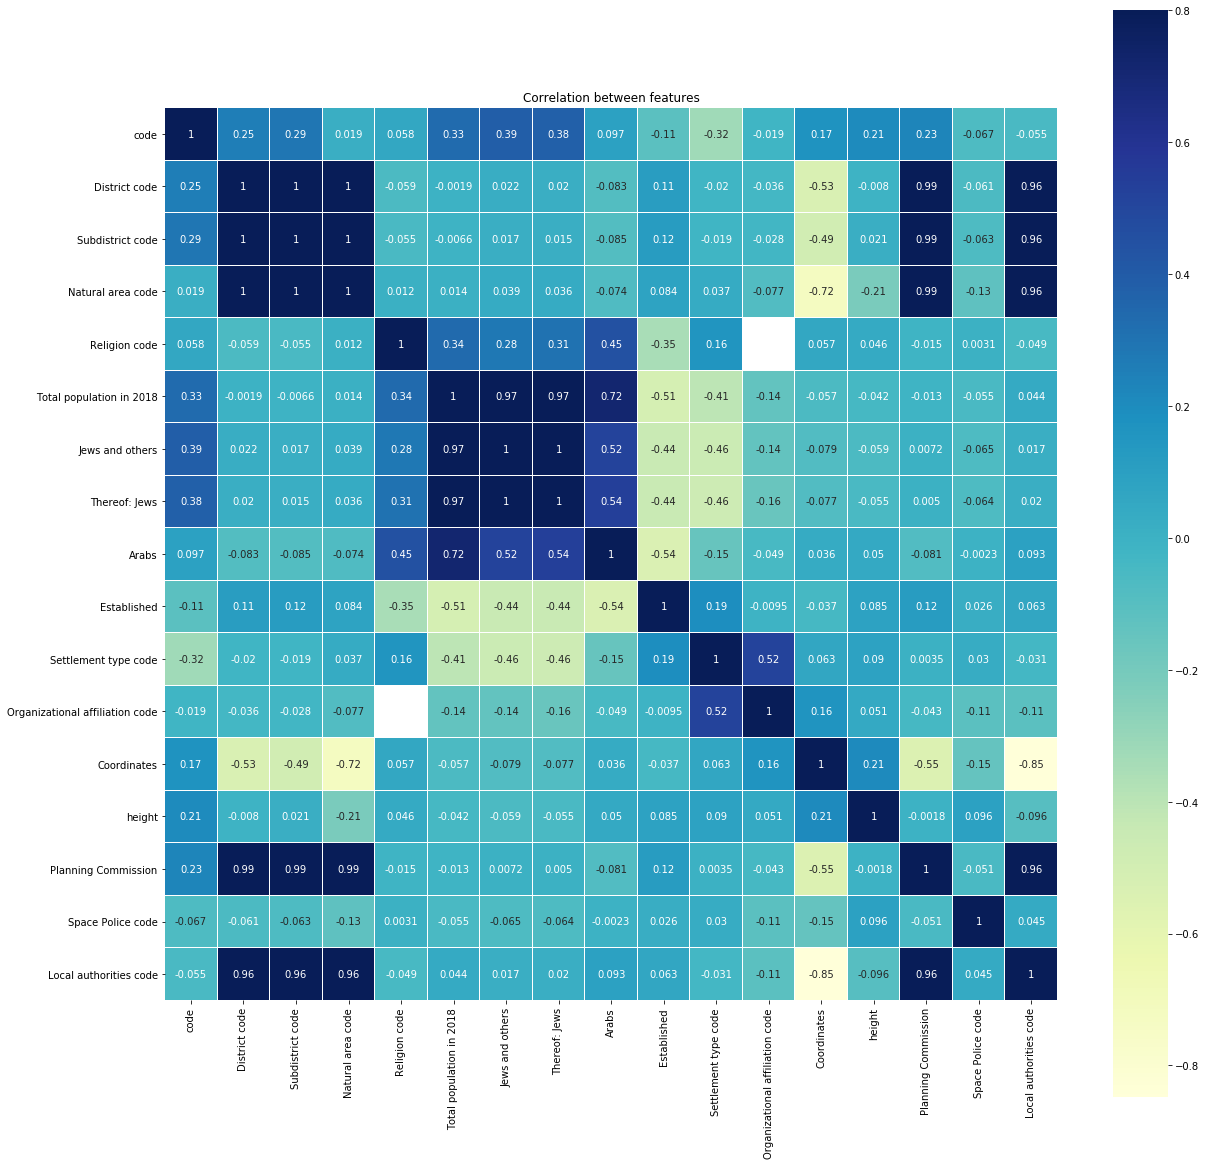

In [109]:
temp=bycode.copy()
temp=temp.astype(float)
corr=temp.corr()
plt.figure(figsize=(20, 20))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');


### Fill  columns
We are filling the dataframe with values that we believe are logical and important to make the correct analysis.

* **Established** - column represents year that the settelment was established, we use the most frequent value to fill the gaps
* **Total population in 2018** - column represents the amount of people living in the settelment, we fill the gaps with the median of the values in this column

* **Arabs/Thereof: Jews/Jews and others** - column represents the amount of people living in the settelment by national, the gaps are filled according to settelment type. if Arab settelment then everyone is from arab national if Jewish settelment then everyone is from Jewish national

* **Height** - column represents the height of the settelment, we fill it with most frequent value in the column.

* **Organizational affiliation code** - column represents the organiztion the settelment belongs to, we put a dummie value "19" to fill gaps

* **Natural area code** - column represents the area of the settelemnt, gaps are filled according to the district they belong to

* **Local authorities code** - column represents the authorities that

* **Religion code** - column reprsents the religion of settelment, gaps are filled according to the national of the settelment

In [110]:
# fill established with most frequent year
bycode["Established"] = pd.to_numeric(bycode["Established"],errors='coerce')
bycode["Established"] = bycode["Established"].fillna(bycode["Established"].value_counts().idxmax())
bycode["Established"] = bycode["Established"].astype(int)

#fill total popluation with median population
bycode["Total population in 2018"] = pd.to_numeric(bycode["Total population in 2018"],errors='coerce')
bycode["Total population in 2018"] = bycode["Total population in 2018"].fillna(bycode["Total population in 2018"].median())
bycode["Total population in 2018"] = bycode["Total population in 2018"].astype(int)

#fill arabs, jews, and other
arabs_code = [250,260,270,280,290,440,450,460]

for index,row in bycode.iterrows():

    if row['Settlement type code'] in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = "0"
        bycode.at[index,"Thereof: Jews"] = "0"
        bycode.at[index,"Arabs"] = row["Total population in 2018"]

    elif row['Settlement type code'] not in arabs_code and pd.isnull(row['Jews and others']):
        bycode.at[index,"Jews and others"] = row["Total population in 2018"]
        bycode.at[index,"Thereof: Jews"] = row["Total population in 2018"]
        bycode.at[index,"Arabs"] = "0"


bycode["Arabs"].fillna("0",inplace = True)
bycode["Thereof: Jews"].fillna("0",inplace = True)
bycode["Jews and others"].fillna("0",inplace = True)

# fill height
bycode["height"].fillna(bycode["height"].value_counts().idxmax(),inplace = True)   

#fill Organizational affiliation
bycode["Organizational affiliation code"].fillna("19",inplace = True)

#fill Natural area code
for index,row in bycode.iterrows():
    if  pd.isnull(row['Natural area code']):
        if row["District code"] == 11:
            bycode.at[index,"Natural area code"] = "111"
        elif row["District code"] in [21,22,23,24,25,29]:
            bycode.at[index,"Natural area code"] = "211"
        elif row["District code"] == [31,32]:
            bycode.at[index,"Natural area code"] = "311"
        elif row["District code"] == [41,42,43,44]:
            bycode.at[index,"Natural area code"] = "411"
        elif row["District code"] == [51,52,53]:
            bycode.at[index,"Natural area code"] = "511"
        elif row["District code"] == [61,62]:
            bycode.at[index,"Natural area code"] = "611"
        
        else:
            bycode.at[index,"Natural area code"] = "0"

#fill Local authorities
bycode["Local authorities code"].fillna(0,inplace = True)

# fill Religion
for index,row in bycode.iterrows():
    if pd.isnull(row['Religion code']):
        if row["Arabs"] == "0":
            bycode.at[index,"Religion code"] = "1"
        else:
            bycode.at[index,"Religion code"] = "2"
            
            
bycode.astype(float,copy=False)
bycode.fillna(0,inplace = True)

# Describe data

### index 2018
This excel just translates the codes from bycode.xlsx to relevant labels

In [111]:
df = pd.read_excel(INDEX)
df

,Subdistrict,District,Subdistrict code
0,Jerusalem,Jerusalem,11
1,Zefat,North,21
2,Kinneret,North,22
3,Jezreel,North,23
4,Acre,North,24
5,Jezreel,North,25
6,Golan,North,29
7,Haifa,Haifa,31
8,Hadera,Haifa,32
9,Hasharon,Center,41


### bycode

This excel contains observations on settelments 

###### Features:
1. **code** - id of the settelment
2. **District code** - id for the area in which the settelment is in
3. **Subdistrict code** - id for the subarea in which the settelment is in
4. **Natural area code** - id for "natural" area that the settelment
5. **Religion code** - id for the main religion of the settelment
6. **Total population in 2018** - the total number if people in the settelment
7. **Jews and others** - total number of non-arabs people in the settelment
8. **Thereof: Jews** - total number of jews in the settelment
9. **Arabs** - total number of arabs in the settelment
10. **Established** - the year the settelment was established in
11. **Settlement type code** - id for the settelment type of the settelment
12. **Organizational affiliation code**	- id for the organization that the settelment is part of
13. **Coordinates** - the coordinates in which the settelment is in
14. **Height** - the height in which the settelment is in
15. **Planning Commission** - id of the commission that dictates the devepopment of the settelment
16. **Space Police code** - the police station to which the settelment belongs to
17. **Local authorities code** - id of the authoritie that manages the settelment


In [112]:
bycode

,code,District code,Subdistrict code,Natural area code,Religion code,Total population in 2018,Jews and others,Thereof: Jews,Arabs,Established,Settlement type code,Organizational affiliation code,Coordinates,height,Planning Commission,Space Police code,Local authorities code
0,967,6,62,623,3,832,0,0,832,1949,460,19,2040057100,50,699,15003711,0
1,472,1,11,111,2,7543,97,79,7446,1949,280,19,2105263481,598,152,10002475,0
3,935,6,62,623,3,832,0,0,832,1949,460,19,1865057450,50,699,10001937,0
4,958,6,62,623,3,832,0,0,832,1949,460,19,1850057900,50,699,10001937,0
5,1042,6,62,623,3,832,0,0,832,1949,460,19,1950056700,50,699,15003711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,665,6,62,621,1,699,699,699,0,1949,310,2,1600359560,109,651,10001930,620
1478,3563,7,76,0,1,3882,3880,3840,2,1977,190,19,2218961753,566,714,15000586,0
1479,970,6,62,623,3,832,0,0,832,1949,460,19,1830056400,50,699,10001946,0
1480,1346,6,62,623,2,1089,6,6,1083,1949,450,19,1752658369,210,624,10001946,610


### 21settelments

Example for settlements file

###### features

1. Committee code - the committee that the settlment belongs to 
2. Code - id of the settelment 
3. Holders of voting rights - people who can vote in settelment
4. Voters - people who actually voted
5. Disqualified - votes that were disqualified
6. Valid votes - valid votes

All the other features show the number of voters for each party 

In [113]:
df = pd.read_excel(SETTELMENT21,dtype=object)
df.drop("name",axis = 1, inplace = True)
df

,committee code,code,Holders of voting rights,Voters,Disqualified,valid votes,Avoda,United Torah Judaism,UAL-Balad,Hadash,...,social justice,Green economy,Ofek Hadash,Me and you,Justice for all,Our Land of Israel,at first,All Israeli brothers and action in Israel,Arab List,Shas
0,17,7,516,371,0,371,17,2,0,0,...,0,0,0,0,0,0,0,0,0,33
1,2,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
2,17,11,403,289,1,288,21,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,18,13,502,403,0,403,44,2,0,0,...,0,0,0,0,3,0,0,0,0,2
4,17,15,302,217,2,215,1,4,0,0,...,0,0,0,0,0,0,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,8,9500,34220,22168,157,22011,925,214,3,9,...,21,4,0,1,27,9,1,8,4,471
1210,8,9600,36506,21114,227,20887,450,123,7,6,...,17,6,0,1,29,9,5,5,18,547
1211,19,9700,45512,34904,104,34800,2652,154,6,38,...,25,2,0,1,34,2,5,2,0,555
1212,9,9800,10073,7652,27,7625,745,13,6,18,...,10,0,0,0,4,0,0,0,1,78


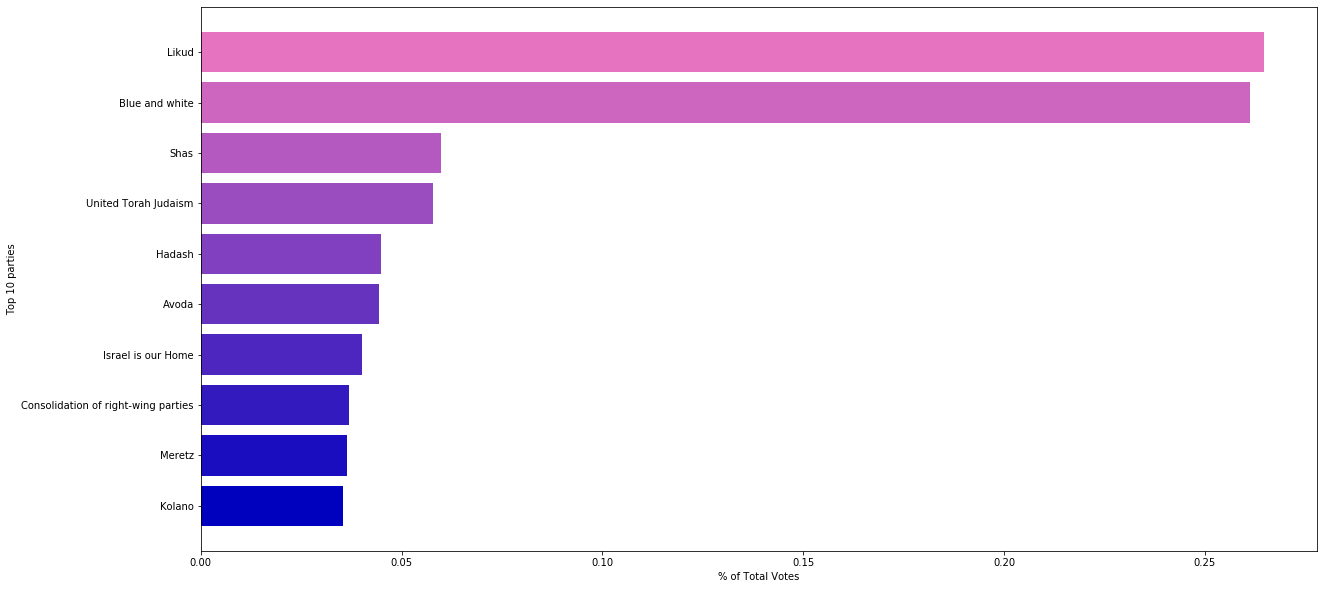

In [114]:
bestparties(df)

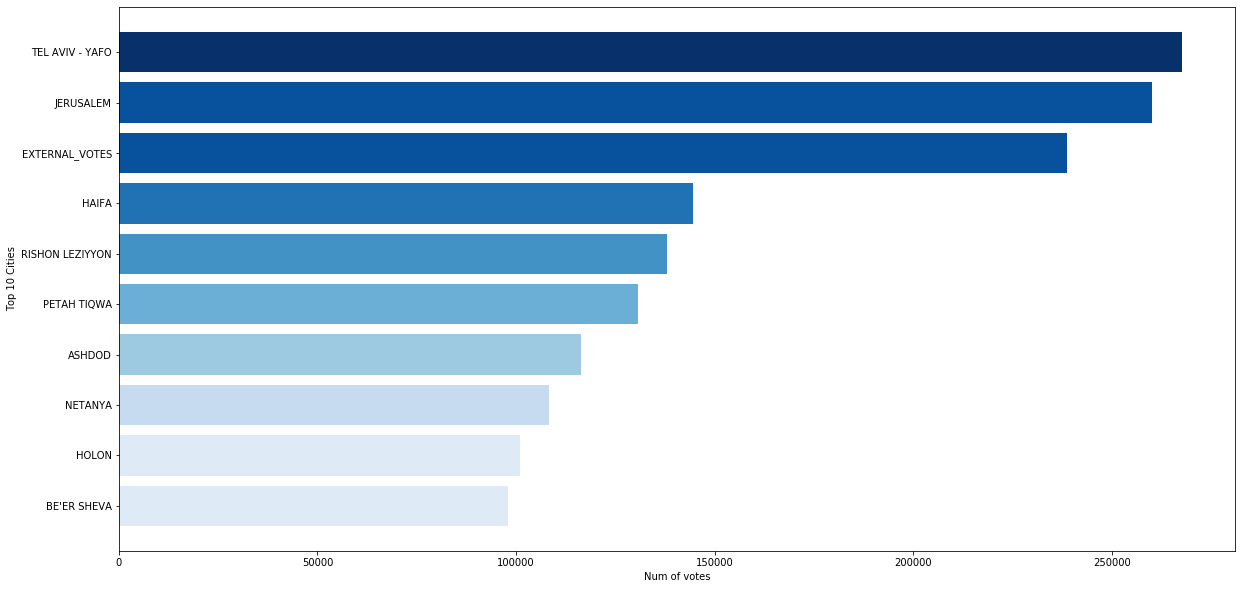

In [115]:
df = pd.read_excel(SETTELMENT21,dtype=object)
biggestCities(df)

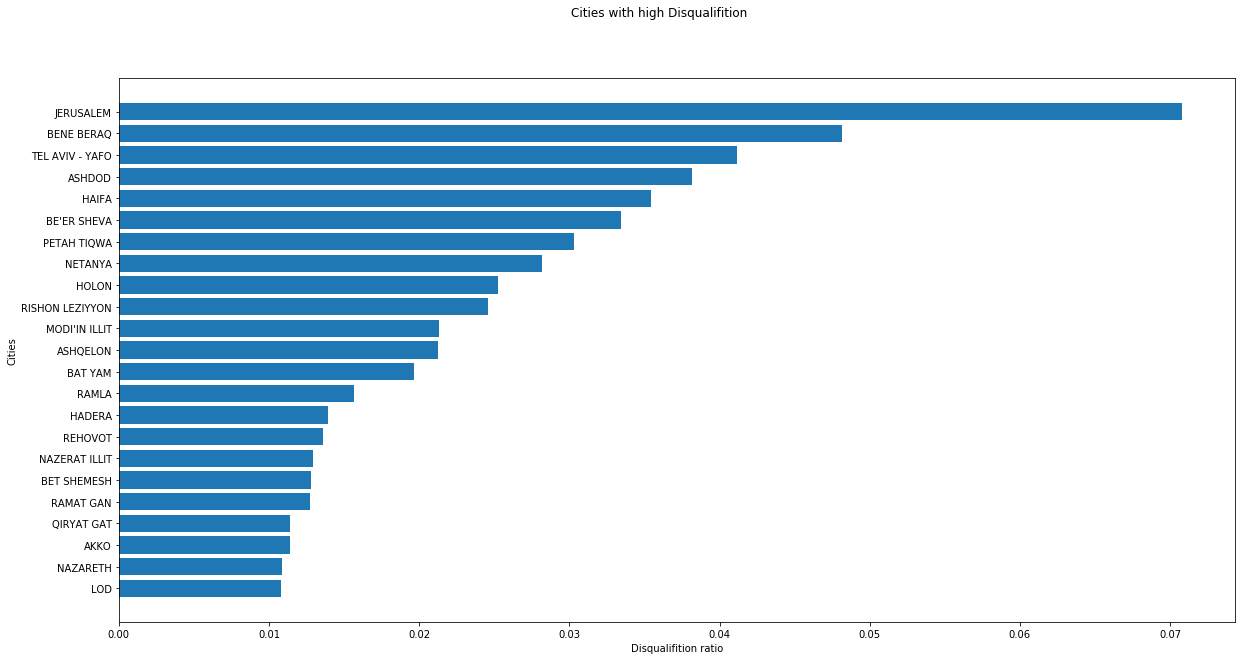

In [116]:
df = pd.read_excel(SETTELMENT21,dtype=object)
df.drop(df.tail(1).index,inplace=True)
df['p']=df['Disqualified']/df['Disqualified'].sum()
df=df.sort_values(by=['p'])
df=df[df['p'] > 0.01]
plt.figure(figsize=(20,10))
plt.barh(df["name"],df['p'],align='center')
plt.xlabel("Disqualifition ratio")
plt.ylabel("Cities")
plt.suptitle("Cities with high Disqualifition")
plt.show()

### calpi21

Example for calpi file

###### features

1. **Code** - settelment id
2. **Calpi_num** - number of calpi in the settelment
3. **Holders of voting rights** - people who can vote in the area of the calpi
4. **Voters** - people who voted in the area of the calpi
5. **Disqualified** - votes that were disqualified in the calpi
6. **Valid votes** - votes that were counted 

All the other features show the number of voters for each party 

In [117]:
df = pd.read_excel(CALPI21,dtype=object)
df.drop("name",axis=1,inplace=True)
df

,code,calpi_num,Holders of voting rights,Voters,Disqualified,valid votes,Avoda,United Torah Judaism,UAL-Balad,Hadash,...,social justice,Green economy,Ofek Hadash,Me and you,Justice for all,Our Land of Israel,at first,All Israeli brothers and action in Israel,Arab List,Shas
0,967,1,546,64,2,62,2,0,31,7,...,0,0,0,0,0,0,1,0,0,0
1,967,2,739,113,2,111,2,0,69,5,...,0,0,0,0,0,2,0,0,0,0
2,967,3,630,98,1,97,1,0,75,1,...,0,0,0,0,0,0,0,0,0,0
3,472,1,518,197,6,191,4,0,36,50,...,0,1,0,0,1,0,0,0,0,1
4,472,2,679,290,3,287,7,0,69,85,...,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10760,3563,2,646,498,0,498,5,10,0,0,...,0,0,0,0,0,0,0,0,0,6
10761,3563,3,690,568,1,567,5,2,0,0,...,0,0,0,0,0,0,0,0,0,8
10762,970,1,496,26,0,26,1,0,11,0,...,0,0,0,0,0,0,0,0,0,1
10763,1346,1,567,143,2,141,0,0,47,9,...,0,0,0,0,5,0,0,1,0,0


# Question 3 - Demographic analysis

Assumptions used:
1. Small parties - that doesnt pass the vote threshold are not representative enough to be considered in the analysis
2. Union of parties - we unite parties with the same political agenda except "Blue and white" and "Likud"
    * **Haredi** - parties that represnt the Hardi communities in israel
    * **Right** - parties that have a right wing politcal agenda
    * **Left** - parties that have a left wing politcal agenda
    * **Arab** - parties that represnt the Arab communities in israel
3. **chosen** - Every settlemnet has a representative party, the one which was voted the most in this settlement
4. **Settlement type** - the settelment type
5. Using results of two election campaigns should give a better indication whether the signal is a coincidence or a real pattern


This way which we approach this problem is by normalizing the dataframe according to the total number of votes that were made in each settelment. By normalizing we get a vector which represents the behavoiur in which the settelment is voting. In this way a large city like jerusalem  can get the same vector as a small kibbutz.

After the normaliziation we start the clustering process and analyze the different clusters created.

In [118]:
index = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
df_21 = pd.read_excel(SETTELMENT21,dtype=object)
df_22 = pd.read_excel(SETTELMENT22,dtype=object)

# using assumptions
df_21 = remove_small_parties(df_21,VOTES_THRESHOLD)
df_21 = unite_parties(df_21)
df_21 = add_most_voted_colm(df_21)

df_22 = remove_small_parties(df_22,VOTES_THRESHOLD)
df_22 = unite_parties(df_22)
df_22 = add_most_voted_colm(df_22)

df = pd.concat([df_21, df_22])

# inner joins to add the settelment type to every settelment observation
df = inner_join(df,bycode,"code")
df = inner_join(df,index,"Settlement type code")
df.fillna(0,inplace = True)

df_base = df[["Likud","Blue and white",'Haredi','Right','Arab','Left',"chosen","Settlement type","valid votes"]]

#### Exploring the dataframe created

In the coorelation matrix there is a little signal that show that  "Blue and White" correlations are very similar to  "Left" correlations.  

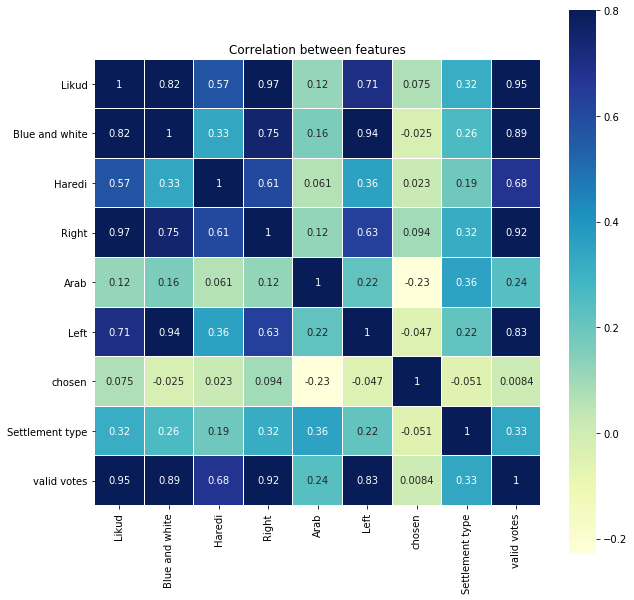

In [119]:
# preparing dataframe for visualiztion
le = LabelEncoder()
df = df_base.copy()
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df["chosen"] = le.fit_transform(df['chosen'])
df = df.astype(int)

# plot corrleation matrix
corr=df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [120]:
# normalizing vectors
df_normalized = normalize_to_voting_ratios(df_base)

# Using PCA to convert the vectors to 3D representation
vectors_vis = pca_conversion(df_normalized)
df_normalized

,Haredi,Right,Arab,Left,Likud,Blue and white
0,0.094340,0.140162,0.000000,0.070081,0.380054,0.266846
1,0.124668,0.103448,0.000000,0.116711,0.339523,0.259947
2,0.323404,0.097872,0.000000,0.021277,0.527660,0.021277
3,0.440816,0.044898,0.000000,0.008163,0.379592,0.024490
4,0.006944,0.128472,0.000000,0.107639,0.291667,0.385417
...,...,...,...,...,...,...
2244,0.048554,0.106330,0.003340,0.150827,0.246640,0.429308
2245,0.370719,0.148118,0.008256,0.062273,0.247569,0.117578
2246,0.409529,0.121680,0.013778,0.070149,0.230013,0.117522
2247,0.098477,0.771574,0.000000,0.002030,0.080203,0.005076


It is possible to see that there are some clusters in this 3D plot

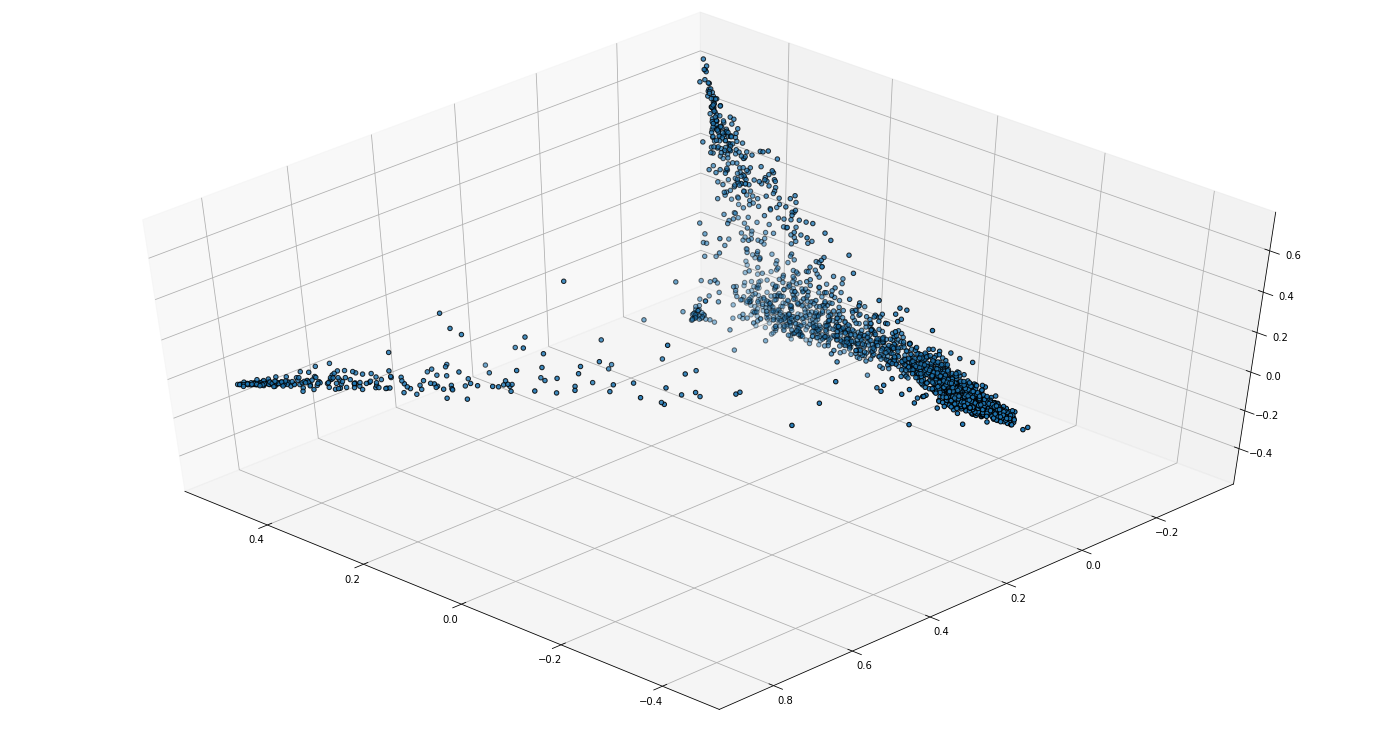

In [121]:
fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(vectors_vis["x"], vectors_vis["y"], vectors_vis["z"], cmap=plt.cm.nipy_spectral,
           edgecolor='k')

### Kmeans

Use case: General-purpose, even cluster size, flat geometry, not too many clusters

Geometry: Distances between points

Evaluation metric:
1. Elbow method  - computes the sum of squared distances from each point to its assigned center.  
2. Silhouette score -  silhouette value is a measure of how similar an object is to its own cluster compared to other clusters

In case the Elbow method is not informative enough we will base our desicion according Silhouette score. 

In [122]:
Sum_of_squared_distances = []
sil  = []
K = range(2,6)

# checking best parameters for kmeans
for k in K:
    km = KMeans(n_clusters=k,random_state=SEED)
    km.fit(df_normalized)
    Sum_of_squared_distances.append(km.inertia_)
    labels = km.labels_
    sil.append(silhouette_score(df_normalized, labels, metric = 'euclidean'))

Elbow method is not informative enough,the angle in which the graph is going is quit consistent

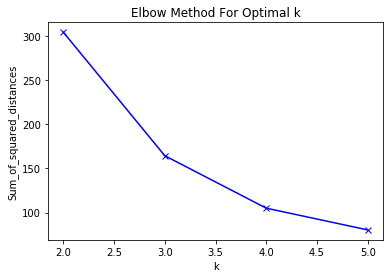

In [123]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We choose K that gives us the highest score for silhouette 

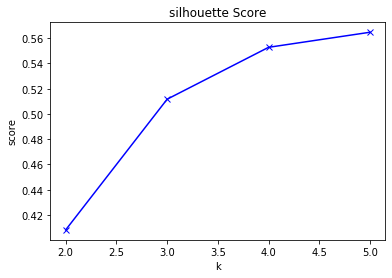

In [124]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('score')
plt.title('silhouette Score')
plt.show()

### Using Kmeans

In this point we are using kmeans with k=5 and add "Cluster Class" column to our base dataframe and the visualization dataframe.

In [125]:
# training model
km = KMeans(n_clusters=5,random_state=SEED)
km.fit(df_normalized)
y = km.predict(df_normalized)

# creating metrics to evaluate the clusters
kmSill=metrics.silhouette_score(df_normalized , y)
kmCalinski=metrics.calinski_harabasz_score(df_normalized , y)
kmDavies=metrics.davies_bouldin_score(df_normalized , y)

df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

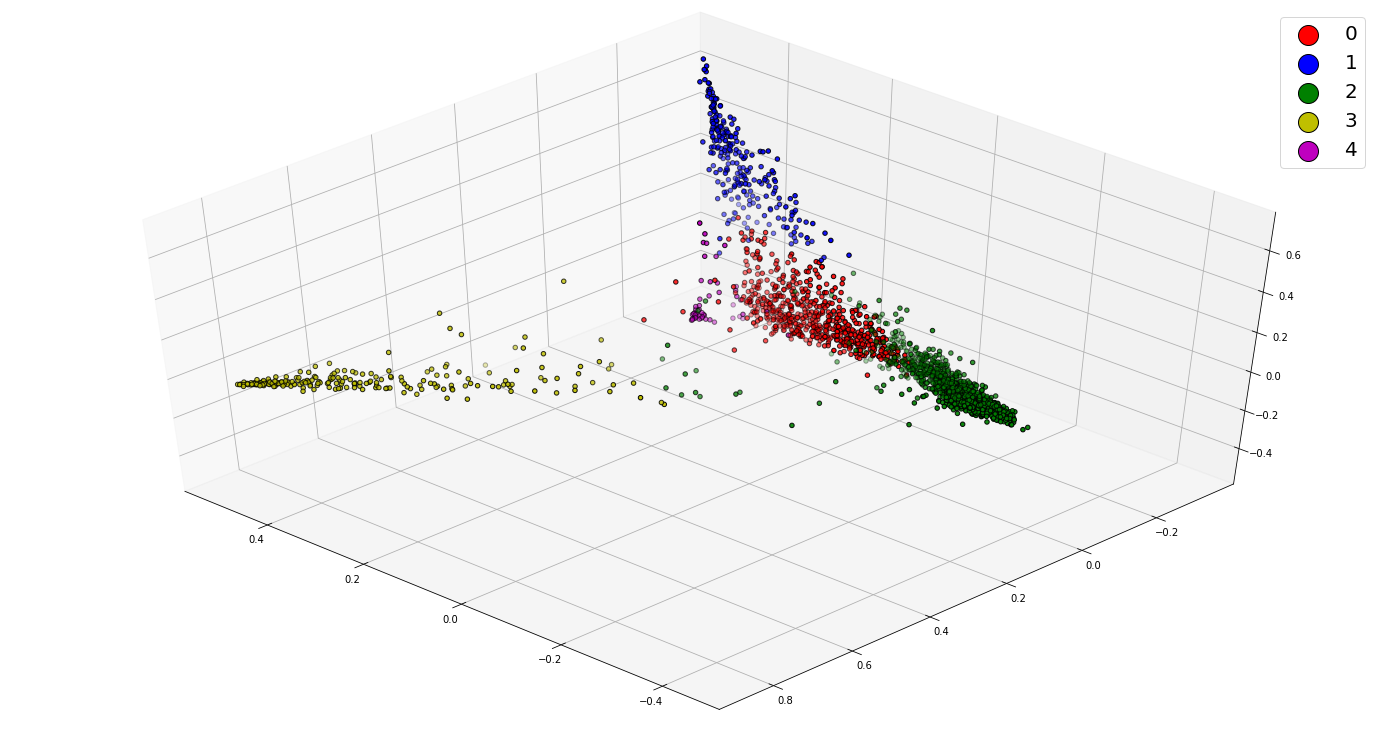

In [126]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

### Analyzing kmeans results

We make two aggregation:
1. We count representative parties in each cluster
2. We count the different types of settelments in each cluster

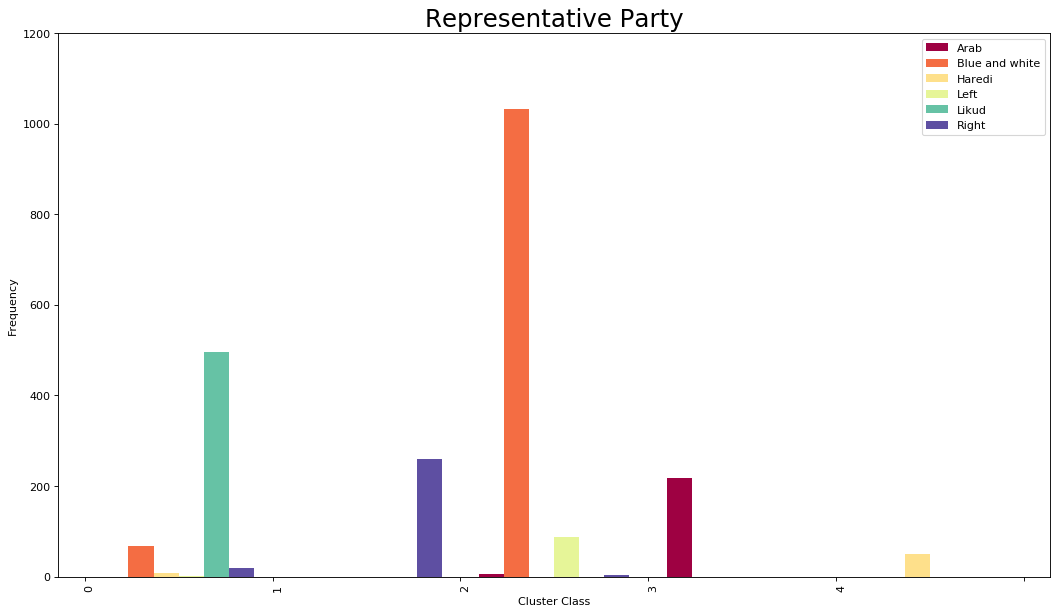

In [127]:
barchar_group(df_base,"Cluster Class","chosen",1200,"Representative Party")

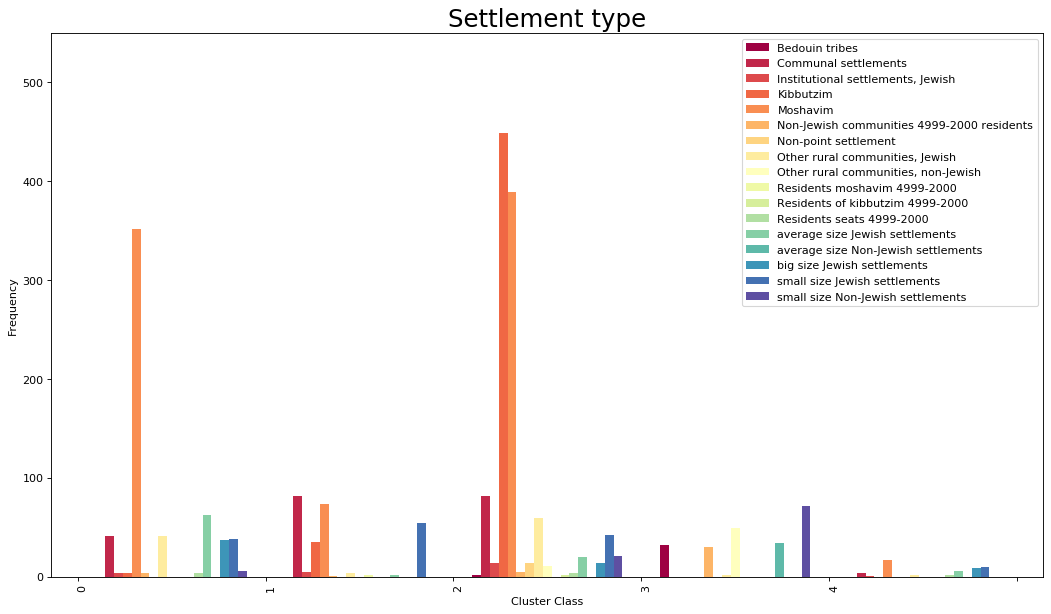

In [128]:
barchar_group(df_base,"Cluster Class","Settlement type",550, "Settlement type")

## Results

The kmeans gave us nice insights, specially on the Kibbutzim and moshavim. In the first graph you can see quit clearly that in one of the clusters  most of the settelments voted mainly to "Blue and White" party and to the "Left" parties. In the second graph you can see that most of the Kibbutzim belong to the same cluster as well and a big number of moshavim.

Those two fact suggest that Kibbutzim and moshavim vote mainly to "Blue and White" and "Left" parties. 

### GMM

Use case: Flat geometry, good for density estimation

Geometry: Mahalanobis distances to  centers
    
Evaluation metric:
1. BIC  - likelihood function, measures how likely the model is correct while giving penalty for overfitting.  
2. Silhouette score - silhouette value is a measure of how similar an object is to its own cluster compared to other clusters

If BIC is not informative enough, we will use Silhouette score 

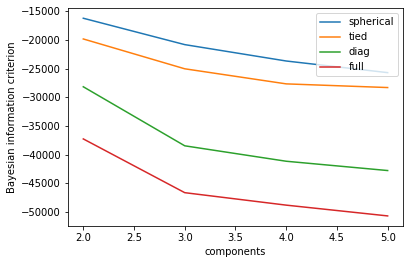

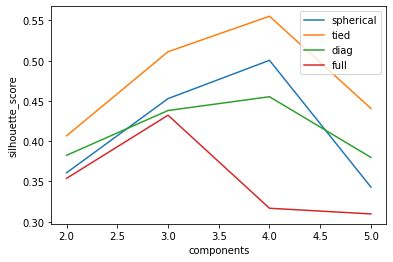

In [129]:
evluate_bic = {}
evluate_sil = {}
n_components_range = range(2, 6)
cv_types = ['spherical', 'tied', 'diag', 'full']

# checking what are the best parameters for GMM
for cv_type in cv_types:
    bic = []
    sil = []
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=SEED)
        gmm.fit(df_normalized)
        bic.append(gmm.bic(df_normalized))
        labels = gmm.predict(df_normalized)
        sil.append(silhouette_score(df_normalized, labels, metric = 'euclidean'))

    evluate_bic[cv_type] = bic
    evluate_sil[cv_type] = sil

# ploting metrics
for key in evluate_bic:
    plt.plot(n_components_range, evluate_bic[key],label=key) # plotting t, c separately 

plt.xlabel("components")
plt.ylabel("Bayesian information criterion")
plt.legend(loc=1)
plt.show()

for key in evluate_sil:
    plt.plot(n_components_range, evluate_sil[key],label=key) # plotting t, c separately 

plt.xlabel("components")
plt.ylabel("silhouette_score")
plt.legend(loc=1)
plt.show()

According to BIC, it looks like that components=5 and covariance_type = full 

In [130]:
# training the models
gmm = mixture.GaussianMixture(n_components=5,covariance_type="full",random_state=SEED)
gmm.fit(df_normalized)
y = gmm.predict(df_normalized)

# creating metrics for evaluation
gmSill=metrics.silhouette_score(df_normalized , y)
gmCalinski=metrics.calinski_harabasz_score(df_normalized , y)
gmDavies=metrics.davies_bouldin_score(df_normalized , y)

df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors_vis['Cluster Class'] = pd.Series(y, index=df_normalized.index)

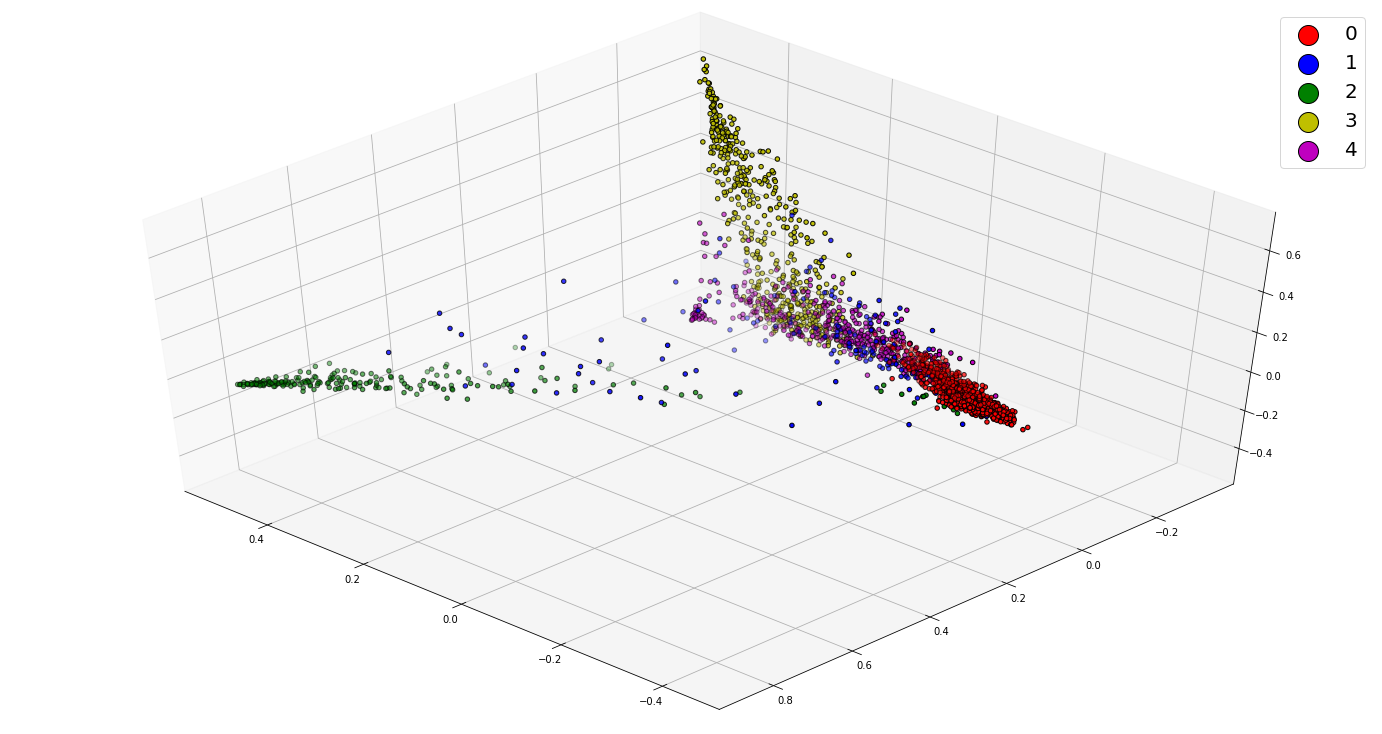

In [131]:
df = vectors_vis.groupby('Cluster Class')

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

colors = itertools.cycle(["r", "b", "g","y","m"])

for name,cluster in df:
    ax.scatter(cluster["x"], cluster["y"], cluster["z"], cmap=plt.cm.nipy_spectral,c=next(colors),
           edgecolor='k',label=name)

lgnd = plt.legend(prop={'size': 20})

#change the marker size manually for both lines
for legendHandle in lgnd.legendHandles:
    legendHandle._sizes = [400]

### Analyzing GMM results

We make two aggregation:
1. We count representative parties in each cluster
2. We count the different types of settelments in each cluster

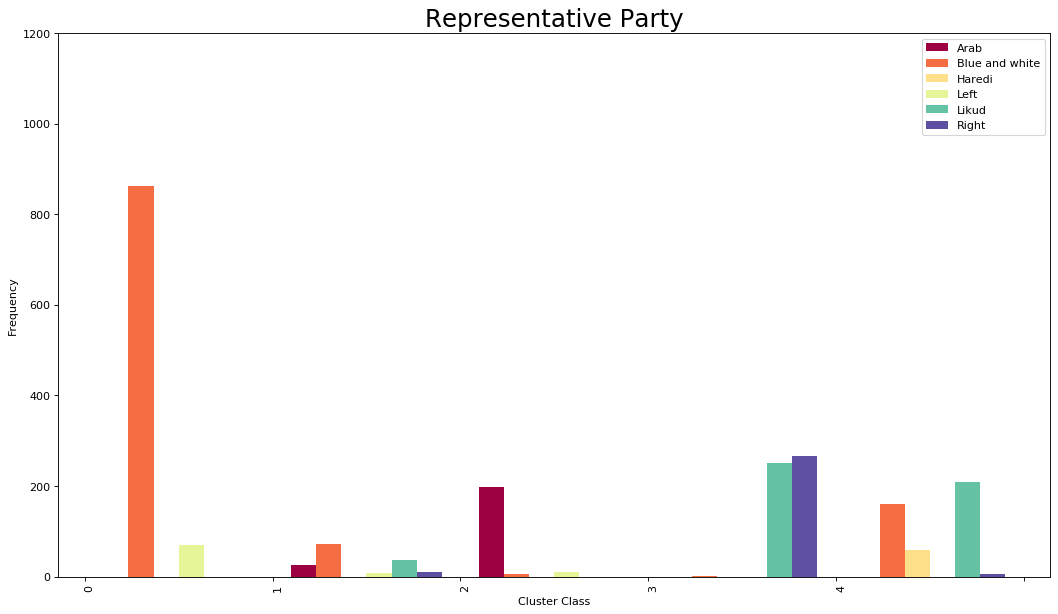

In [132]:
barchar_group(df_base,"Cluster Class","chosen",1200,"Representative Party")

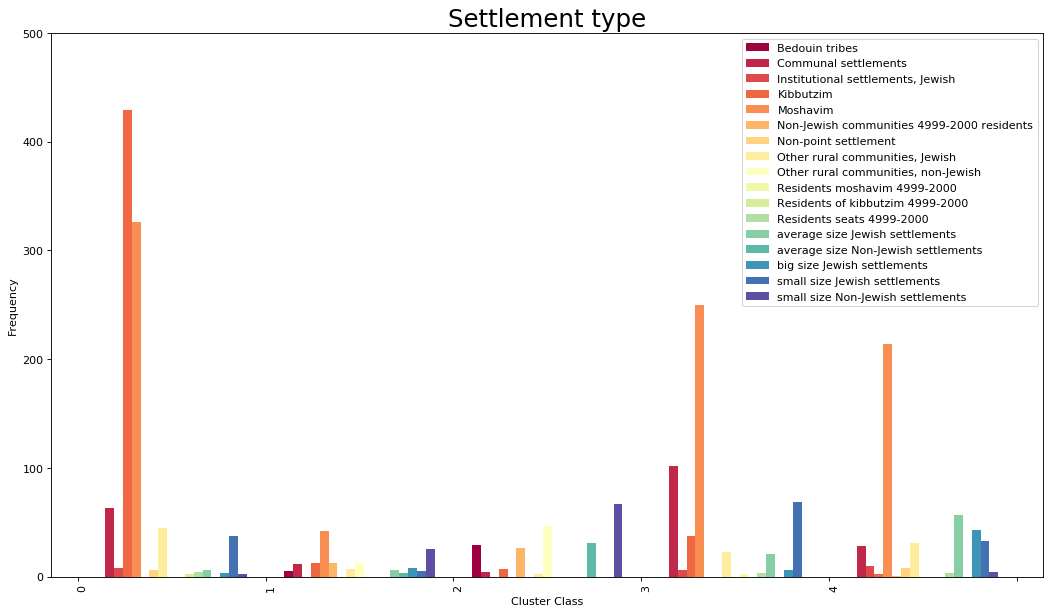

In [133]:
barchar_group(df_base,"Cluster Class","Settlement type",500,"Settlement type")

### Results

GMM as well gives us some insights. In one of the clusters in the first graph there is high concentration of "Blue and White" and "Left" parties. In the second graph you can see that Kibbutzim are mainly concentrated in the same cluster.

So GMM suggests that most of the kibbutzim are voting mainly for "Blue and white".

### KMeans vs GMM 

In this case kmeans preformed better then GMM. Kmeans managed to identify small clusters in the dataset, for example the "Haredi" party and distinguish them from the other clusters. While GMM mixed "Haredi" party with other parties.

Why kmeans preformed better? One reason could be that GMM flexibility, which means that he is more tolerant to the distance of the data from the cluster and another reason could be that GMM work better if the data in each feature are Normal distributed.

in the output bellow we present a 3 scores approaches: 
 1. **Sillhoutte** score  where a high value indicates that the object is well matched to its own cluster and poorly      matched to neighboring clusters.
 2. **Calinski-Harabasz** the score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. The higher the value  the better is the solution.
 3. **Davies-Bouldin** score ,it is defined as a ratio between the cluster scatter and the cluster’s separation and a lower value will mean that the clustering is better.
 
 *in the comparation between kmeans and gmm , kmeans best gmm in all 3 scores.

In [134]:
print("kmean sillhoutte score : "+str(kmSill) )
print("gmm sillhoutte score : "+str(gmSill) )
print("")
print("kmean Calinski-Harabasz  score : "+str(kmCalinski))
print("gmm Calinski-Harabasz  score : "+str(gmCalinski))
print("")
print("kmean Davies score : "+str(kmDavies))
print("gmm Davies score : "+str(gmDavies))

kmean sillhoutte score : 0.5646686326288168
gmm sillhoutte score : 0.30964184707110803

kmean Calinski-Harabasz  score : 2666.519387937981
gmm Calinski-Harabasz  score : 1041.7872239070364

kmean Davies score : 0.5829348968768586
gmm Davies score : 1.710831418960833


# Question 4 - RandomForest predicts valid votes

###### features
Features used are the ones that are present in bycode.xlsx. The reason we are using only those is because of the time element which makes problem logicaly using the data from the settelments file.

In [135]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None,'log2'],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}


df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "valid votes"

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

TEST=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df_test = df23[df23['name'].isin(TEST)]
locations=df_test['name'].values.tolist()

# preparing data for training and testing
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# selecting features according to importance and transformig data accordingly
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)


# trainning model and testing
rs = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, n_jobs=-1,
                        scoring='neg_mean_absolute_error', cv=5,
                        verbose=1)
rs.fit(x_train,y_train)
model = rs.best_estimator_
predict_y = rs.predict(x_test)

print("MAE score: "+str(metrics.mean_absolute_error(predict_y,y_test)))
print("features used:")
print(features[sfm.get_support()].values)

      
pred = pd.DataFrame(predict_y,columns=["prediction"],index = locations)
test = pd.DataFrame(y_test.values,columns=["actual"],index = locations)
        
results =  pd.concat([pred,test], axis=1)
results

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.2min finished


MAE score: 329.9
features used:
['Total population in 2018' 'Jews and others' 'Thereof: Jews']


,prediction,actual
AYYELET HASHAHAR,580.0,585
ELAT,22699.0,22636
HAIFA,144310.0,144625
SAKHNIN,15833.0,17085
QAZRIN,3483.5,3498


In [136]:
fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data', xaxis_title="Settlements",
    yaxis_title="Number of votes",)
fig.show()

# Question 5 - Adaboost predicts votes for parties

###### features
Features used are the ones that are present in bycode.xlsx. The reason we are using only those is because of the time element which makes problem logicaly using the data from the settelments file.

In [137]:
adb_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'random_state': [1]}


# preparing data
df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))

df21 = inner_join(bycode,df21,"code")
df22 = inner_join(bycode,df22,"code")
df23 = inner_join(bycode,df23,"code")

df_train = pd.concat([df21, df22])

cities=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df_test = df23[df23.name.isin(cities)]


### Likud votes prediction

In [138]:
# model for likud
target = "Likud"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# choosing features
sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

gsADB = GridSearchCV(AdaBoostRegressor(random_state=SEED),param_grid = adb_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print("MAE score: "+str(metrics.mean_absolute_error(y_predict,y_test)))
print("features used:")
print(features[sfm.get_support()].values)

pred = pd.DataFrame(y_predict,columns=["prediction"],index = df_test["name"])
test = pd.DataFrame(y_test.values,columns=["actual"],index = df_test["name"])
        
results =  pd.concat([pred,test], axis=1)
results


MAE score: 2350.7418518518516
features used:
['Total population in 2018' 'Jews and others' 'Thereof: Jews' 'Arabs'
 'Settlement type code']


,prediction,actual
name,,
BENE BERAQ,4279.500000,4951
DALIYAT AL-KARMEL,124.257851,407
JERUSALEM,62394.466667,72601
KARMI'EL,8371.324074,8879
SAKHNIN,124.257851,39


In [139]:
fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Blue and White predictions

In [140]:
# model for Blue and White
target = "Blue and white"

x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# feature selection
sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

# training model with cross-validation
gsADB = GridSearchCV(AdaBoostRegressor(random_state=SEED),param_grid = adb_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print("MAE score: "+str(metrics.mean_absolute_error(y_predict,y_test)))
print("features used:")
print(features[sfm.get_support()].values)



pred = pd.DataFrame(y_predict,columns=["prediction"],index = df_test["name"])
test = pd.DataFrame(y_test.values,columns=["actual"],index = df_test["name"])
        
results =  pd.concat([pred,test], axis=1)
results

MAE score: 4329.546629901961
features used:
['Total population in 2018' 'Jews and others' 'Thereof: Jews' 'Arabs'
 'Established']


,prediction,actual
name,,
BENE BERAQ,9137.019608,1133
DALIYAT AL-KARMEL,227.059671,5200
JERUSALEM,40120.250000,32800
KARMI'EL,5383.536458,6627
SAKHNIN,227.059671,120


In [141]:
fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

### Join list predictions

In [142]:

# model for Joint List
target = "Arabs"
x_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

# feature selection
sfm = SelectFromModel(AdaBoostRegressor())
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)

# training model with cross-validation
gsADB = GridSearchCV(AdaBoostRegressor(random_state=SEED),param_grid = adb_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs= -1)
gsADB.fit(x_train,y_train)

adb = gsADB.best_estimator_

y_predict = adb.predict(x_test)
print("MAE score: "+str(metrics.mean_absolute_error(y_predict,y_test)))
print("features used:")
print(features[sfm.get_support()].values)




pred = pd.DataFrame(y_predict,columns=["prediction"],index = df_test["name"])
test = pd.DataFrame(y_test.values,columns=["actual"],index = df_test["name"])
        
results =  pd.concat([pred,test], axis=1)
results


MAE score: 438.4994080106313
features used:
['Arabs' 'Planning Commission']


,prediction,actual
name,,
BENE BERAQ,148.937747,64
DALIYAT AL-KARMEL,17299.387097,17382
JERUSALEM,349572.000000,349572
KARMI'EL,164.925951,1507
SAKHNIN,31713.872340,31031


In [143]:
fig = go.Figure(data=[
    go.Bar(name='Test', x=results.index, y=results['actual'],  textposition='auto', 
           marker_color='rgb(255,51,51)', marker_line_color='rgb(8,48,107)',marker_line_width=1, opacity=0.6),
    go.Bar(name='Pred', x=results.index, y=results['prediction'],  textposition='auto',
           marker_color='rgb(102,178,255)', marker_line_color='rgb(30,70,70)',marker_line_width=1, opacity=0.6)
])

# Change the bar mode
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Comparison between prediction and actual data',
    yaxis_title="Number of votes",)
fig.show()

# Question 6 - Minimize disqualified votes

###### features
Features used are the ones that are present in bycode.xlsx. The reason we are using only those is because of the time element which makes problem logicaly using the data from the settelments file.

In [144]:

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

features = np.delete(bycode.columns,np.where(bycode.columns== "code"))
target = "class"
columns = np.append(features,target)

def label(row,total):
    """checks if the settelment has high amount of disqualified votes"""
    
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

def add_class(df):
    """adds a class to each observation in the dataframe """
    
    settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
    total = df["Disqualified"].sum()
    
    df['class'] = df.apply(lambda row : label(row, total), axis = 1)
    df = inner_join(df,bycode,"code")
    df = inner_join(df,settlment_type,"Settlement type code")

    df['Settlement type'] = le.fit_transform(df['Settlement type'])
    return df ,df[columns]



In [145]:
df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

_,df21 = add_class(df21)
_,df22 = add_class(df22)
df, df23 = add_class(df23)

df_train=pd.concat([df21, df22])

y_train = df_train[target]
x_train= df_train[features]

y_test = df23[target].copy()
x_test = df23[features].copy()

# Estimator for use in random search
rs = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)

# choosign best features for the modle
sfm = SelectFromModel(rs.estimator)
sfm.fit(x_train, y_train)
x_train = sfm.transform(x_train)
x_test = sfm.transform(x_test)



# Create the random search model
rs = RandomizedSearchCV(RandomForestClassifier(random_state = SEED), param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)
rs.fit(x_train,y_train)
y_predict = rs.predict(x_test)

print("accuracy: "+str(metrics.accuracy_score(y_predict,y_test)))
print("features used:")
print(features[sfm.get_support()].values)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


accuracy: 0.9991111111111111
features used:
['Total population in 2018' 'Jews and others' 'Thereof: Jews'
 'Settlement type code']


Confusion matrix, without normalization


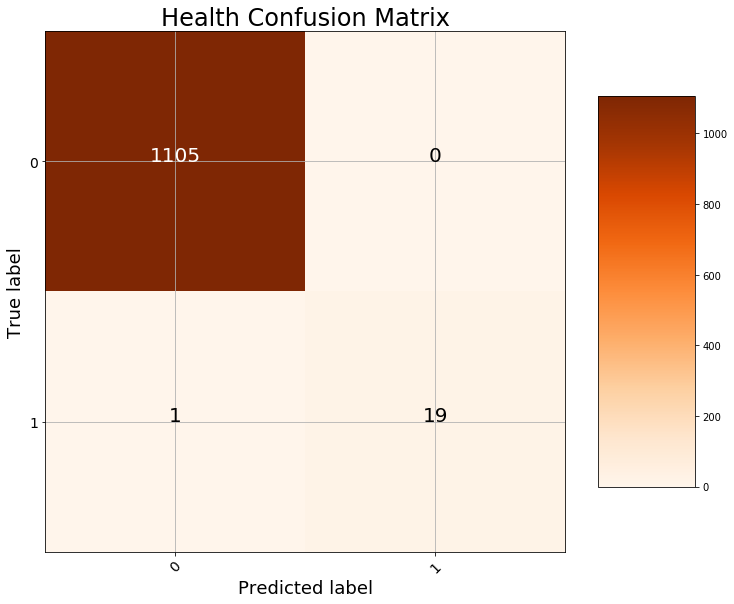

In [146]:
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')

In [147]:
df["predict"] = y_predict
df=df[df.predict == 1]
print(df.name)

1046             HADERA
1047                LOD
1048      MODI'IN ILLIT
1054              RAMLA
1080             ASHDOD
1081        BE'ER SHEVA
1082              HAIFA
1083            NETANYA
1084        PETAH TIQWA
1085    RISHON LEZIYYON
1086    TEL AVIV - YAFO
1087           ASHQELON
1088        BET SHEMESH
1089         BENE BERAQ
1090            BAT YAM
1091              HOLON
1093            REHOVOT
1094          RAMAT GAN
1116          JERUSALEM
Name: name, dtype: object
